In [36]:
import numpy as np
from scipy.stats import chi2
import scipy.integrate
import matplotlib.pyplot as plt

from sklearn.datasets import make_blobs

In [37]:
def gen_data(k, dim, points_per_cluster, lim, spread):
    # select n_clusters by sampling from a uniform distribution
    centers = np.random.uniform(lim[0], lim[1], (k, dim))
    # select cluster_std by sampling from a uniform distribution
    cluster_std = np.random.uniform(spread[0], spread[1], k)
    # make blobs with sklearn
    X, y = make_blobs(n_samples=points_per_cluster, cluster_std=cluster_std, centers=centers, n_features=dim, random_state=1)
    return X, y

def plot_data(x, y=None):
    dim = x.shape[1]
    fig = plt.figure()
    ax = fig.gca()

    if y is None:

        if (dim == 1):
            ax.scatter(x, np.zeros_like(x), s=10, alpha=0.4)
            #ax.set_xlim(-0.1, 1.1)
            ax.set_ylim(-0.05, 1)
        if(dim == 2):
            ax.scatter(x[:,0], x[:,1], s=3, alpha=0.4)
            ax.autoscale(enable=True)
    else:
        k_clusters = len(np.unique(y))
        if dim == 1:
            for i in range(k_clusters):
                ax.scatter(x[y == i], np.zeros_like(x[y == i]), s=10, label=f"Cluster{i}", alpha=0.4)
            # ax.set_xlim(-0.1, 1.1)
            ax.set_ylim(-0.05, 1)
        if dim == 2:
            for i in range(k_clusters):
                plt.scatter(x[y == i, 0], x[y == i, 1], s=3, label=f"Cluster{i}", alpha=0.4)

def predict(igmn, n_samples, min, max, filter_n):
    x = np.linspace(min, max, n_samples)
    y = [igmn.predict([x_i], filter_n=filter_n) for x_i in x]
    return x.reshape((-1,)), y

def plot_gmm(X, Y, x_min, x_max, x, y):
    """Plot the density function based on samples from a GMM."""
    fig = plt.figure()
    ax = fig.gca()

    # plot the original data
    # ax.scatter(X, np.zeros_like(X), s=10, alpha=0.1, label='Data')
    k_clusters = len(np.unique(Y))
    for i in range(k_clusters):
        ax.scatter(X[Y == i], np.zeros_like(X[Y == i]), s=10, label=f"Cluster{i}", alpha=0.4)

    
    # plot the GMM density function
    ax.plot(x, y, color="green", alpha=0.2)
    ax.set_ylim(-0.05, 1)
    ax.set_xlim(x_min, x_max)

In [38]:
class IGMN:
    """Incremental Gaussian Mixture Network

    Implements the IGMN algorithm as described in:
        - https://journals.plos.org/plosone/article/file?id=10.1371/journal.pone.0139931&type=printable

    Args:
        input_dim (int): dimension of the input data
        beta (float): confidence level for the chi-square test
        all_adults_criterion (bool): whether to use the all_adults_criterion
        age_min (int): minimum age for a component to be considered an adult
        acc_min (float): minimum accumulation for a component to be considered an adult
        max_components (int): maximum number of components in the model
        rank_type (str): type of covariance matrix to use, either "full" or "diag"
        closest_n (int): number of closest components to merge into
    """
    def __init__(self, input_dim, beta, all_adults_criterion, age_min, acc_min, max_components, rank_type, closest_n):
        self.input_dim = input_dim

        # hyperparameters
        self.beta = beta
        self.all_adults_criterion = all_adults_criterion
        self.age_min = age_min
        self.acc_min = acc_min
        self.max_components = max_components
        self.rank = rank_type
        self.closest_n = closest_n

        # components
        self.components = []

    def create_new_component(self, x, components):
        """Create a new component with the given input x

        As described in section 2.2 (Creating new components)
        """
        mu = x
        acc = 1
        age = 1

        # p => mixing coefficient
        if len(components) > 0:
            p = 1 / (sum([comp['acc'] for comp in components]) + 1)
        else:
            p = 1

        sigma_ini = 0.01
        sigma = sigma_ini * np.eye(len(x)) # equation 13
        return {"mu": mu, "sigma": sigma, "p": p, "acc": acc, "age": age}

    
    def remove_spurious_components(self):
        """A component j is removed whenever u_j > u_min and sp_j < sp_min, where u_min and sp_min are user-defined thresholds.

        In that case, also, p(k) must be adjusted for all k in K (with k != j).
        In other words, each component is given some tim eu_min to show its importance to the model in the form of an accumulation of its posterior probability sp_j

        As described in section 2.3 (Removing spurious components)
        """
        for j, component_j in enumerate(self.components):
            if component_j['age'] > self.age_min and component_j['acc'] < self.acc_min:
                # print("Removing component ", j)
                self.components.pop(j)
        self.update_priors()

    def squared_mahalanobis_distance(self, x, mu, cov):
        """Squared Mahalanobis distance for a multivariate gaussian distribution"""
        sigma_inv = np.linalg.inv(cov)
        diff = x - mu # error vector
        d_sq = diff.T @ sigma_inv @ diff
        return d_sq.item()
    
    def pdf(self, x, mu, cov):
        """Multivariate Gaussian PDF"""
        D = self.input_dim
        d_sq = self.squared_mahalanobis_distance(x, mu, cov) # equation 1
        norm_constant = 1 / np.sqrt((2 * np.pi) ** D * np.linalg.det(cov)) 
        return norm_constant * np.exp(-0.5 * d_sq) # equation 2

    def update_with_x(self, component_j, x):
        """Equations 2 to 12 in the paper"""
        denom = 0
        for comp in self.components:
            p_x_k = self.pdf(x, comp['mu'], comp['sigma'])
            denom += p_x_k * comp['p']

        p_x_j = self.pdf(x, component_j['mu'], component_j['sigma']) # equation 2
        p_j_x = (p_x_j * component_j['p']) / denom # equation 3
        component_j['age'] = component_j['age'] + 1 # equation 4
        component_j['acc'] = component_j['acc'] + p_j_x # equation 5
        e_j = x - component_j['mu'] # equation 6
        omega_j = p_j_x / component_j['acc'] # equation 7
        delta_mu_j = omega_j * e_j # equation 8
        component_j['mu'] = component_j['mu'] + delta_mu_j # equation 9
        e_j2 = x - component_j['mu'] # equation 10

        
        copy = component_j["sigma"].copy()

        # clip delta_mu_j to avoid making the covariance matrix non positive definite
        delta_mu_j = np.clip(delta_mu_j, -0.01, 0.01) # TODO: find a better way to clip this value
        # analysis of why this can get non-positive:
        # term 1: 1-omega_j is a scalar, copy is a matrix -> term is positive definite
        # term 2: + (e_j2 @ e_j2.T) 
        #               1. outer-product of a vector with itself -> positive definite, 
        #               2. multiplication by scalar omega_j -> positive definite,
        #               3. addition of two positive definite matrices -> positive definite
        # term 3: - (delta_mu_j @ delta_mu_j.T)
        #               1. outer-product of a vector with itself -> positive definite
        #               2. BUT subtraction of two positive definite matrices -> not necessarily positive definite
        # BUT if delta_mu_j is too large, it can make the matrix non-positive definite
        # I currently clip delta_mu_j to avoid this issue, but it is not the best solution as I am losing information
        component_j["sigma"] = \
            (1 - omega_j) * copy \
            + omega_j * (e_j2 @ e_j2.T) \
            - delta_mu_j @ delta_mu_j.T # equation 11
        
        # do not use full rank covariance matrix, only keep variances
        if self.rank == "diag":
            component_j["sigma"] = np.diag(np.diag(component_j["sigma"]))
        
        if not np.all(np.linalg.eigvals(component_j["sigma"]) > 0):
            raise ValueError("Sigma is not positive definite")
        
        component_j['p'] = component_j['acc'] / sum([comp['acc'] for comp in self.components]) # equation 12

    def update_priors(self):
        total_acc = sum([comp['acc'] for comp in self.components])
        for comp in self.components:
            comp['p'] = comp['acc'] / total_acc

    def update(self, x):
        # section 2.2 - creating new components
        if not self.components:
            # print("No components yet, creating new one")
            new_component = self.create_new_component(x, self.components)
            self.components.append(new_component)
            return
        
        # section 2.3 - removing spurious components
        self.remove_spurious_components()
        
        # section 2.2 - learning
        updated = False
        chi_sq_threshold = chi2.ppf(1-self.beta, self.input_dim)
        for component_j in self.components:

            d_sq = self.squared_mahalanobis_distance(x, 
                                                     component_j['mu'], 
                                                     component_j['sigma']) # equation 1)
            
            # check if d_sq is negative and throw error otherwise
            if d_sq < 0:
                raise ValueError(f"Negative squared Mahalanobis distance: {d_sq} based on x = {x}, mu = {component_j['mu']}, sigma = {component_j['sigma']}")

            if d_sq < chi_sq_threshold:
                self.update_with_x(component_j, x)
                updated = True

        # criterion 2: only create a new neuron if all neurons of that model have an age greater than the parameter age_min (taken from follow-up paper -> IGMN-NSE paper)
        all_adults = all([comp['age'] > self.age_min for comp in self.components]) if self.all_adults_criterion else True
        
        if not updated and all_adults:
            if len(self.components) < self.max_components:
                new_component = self.create_new_component(x, self.components)
                self.components.append(new_component)
            else:
                self.merge_to_closest_n(x)

        self.update_priors()

    def merge_to_closest_n(self, x):
        distances = []
        for component in self.components:
            d_sq = self.squared_mahalanobis_distance(x, 
                                                     component['mu'], 
                                                     component['sigma'])

            distances.append(d_sq)

        # sort the components by distance
        sorted_components = [comp for _, comp in sorted(zip(distances, self.components))]
        closest_components = sorted_components[:self.closest_n]

        for comp in closest_components:
            self.update_with_x(comp, x)


    def predict(self, x, filter_n=None):
        components = self.components
        if filter_n:
            components = sorted(components, key=lambda c: c["p"], reverse=True)[:filter_n].copy()

            total_acc = sum([comp['acc'] for comp in components])
            for comp in components:
                comp['p'] = comp['acc'] / total_acc
        
        prob = 0
        for comp in components:
            p_x_j = self.pdf(x, comp['mu'], comp['sigma'])
            p = comp['p']
            prob += p_x_j * p
        return prob

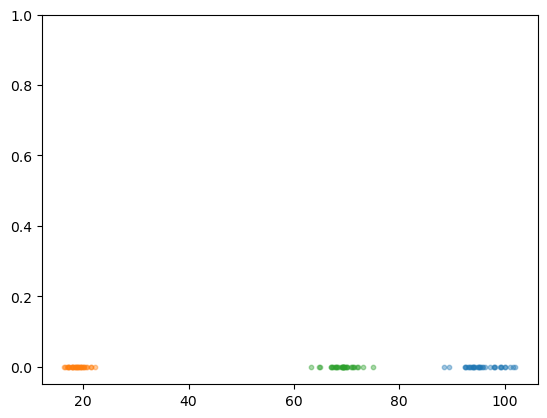

In [39]:
# TODO: the scale matters a lot, if the scale is too small (between 0 and 1, the predictions do not make sense)
X, Y = gen_data(k=3, dim=1, points_per_cluster=100, lim=[0, 100], spread=[1, 5])

# shuffle X and Y (but keep the correspondence)
p = np.random.permutation(len(X))
X, Y = X[p], Y[p]
plot_data(X, Y)

Number of components:  17
Components centered at:  [99.52226974909067, 94.39002978238655, 19.182942923694732, 17.996082519246233, 69.10380614004228, 101.84254074053051, 70.00149927403827, 73.14417249751432, 17.208544416848607, 89.37325697379451, 71.1721654396598, 98.02071208181103, 64.91076164636452, 63.225337353424095, 88.56977425960201, 75.008519217648, 101.09690858029738]
IGMN has  17  components
GMM integral:  0.9989206371524885  or  (0.9999998505177138, 0.061113126017369054)


/var/folders/6f/cghf9hrs70152srqk9l_dcch0000gn/T/ipykernel_35467/3362467635.py:31: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  print("GMM integral: ", scipy.integrate.simpson(y, x), " or ", scipy.integrate.quad(lambda x: igmn.predict(x), -50, 150))


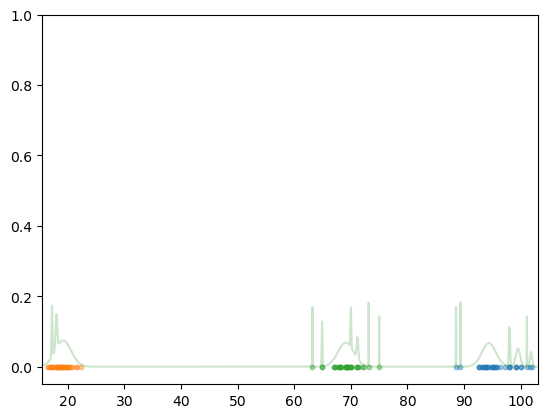

In [45]:
igmn = IGMN(input_dim=1, beta=0.0001, all_adults_criterion=False, age_min=5.0, acc_min=3.0, max_components=20, rank_type = "diag", closest_n=20)
idx = 0
looped = 0

for i in range(2000+1):
    # next sample
    x = X[idx]
    
    # print every 100th iteration
    #if (idx % 100) == 0:
    #    print("Iteration: ", (len(X) * looped) + idx)

    # update the model with new sample
    igmn.update(x)

    # update index
    idx += 1
    # loop again over indices if we reached the end
    if idx == len(X):
        idx = 0
        looped += 1

print("Number of components: ", len(igmn.components))
print("Components centered at: ", [comp['mu'].item() for comp in igmn.components])

x_min, x_max = min(X)-1, max(X)+1
n_samples = 100000
x, y = predict(igmn, n_samples, x_min, x_max, filter_n=None)

print("IGMN has ", len(igmn.components), " components")
print("GMM integral: ", scipy.integrate.simpson(y, x), " or ", scipy.integrate.quad(lambda x: igmn.predict(x), -50, 150))
plot_gmm(X, Y, x_min, x_max, x, y)


### GMM

In [41]:
from sklearn.mixture import GaussianMixture

def predict2(gmm, n_samples, x_min, x_max):
    x = np.linspace(x_min, x_max, n_samples)
    y = [np.exp(gmm.score_samples([x_i])) for x_i in x]
    return x, y

In [42]:
gmm = GaussianMixture(n_components=20, covariance_type="diag")
gmm.fit(X);

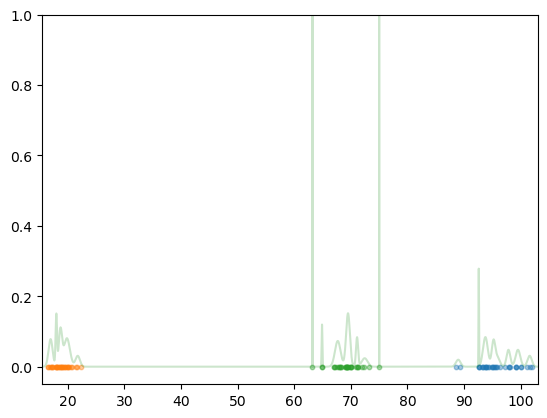

In [43]:
x, y = predict2(gmm, n_samples, x_min, x_max)

plot_gmm(X, Y, x_min, x_max, x, y)